In [2]:
# training GANS is a slow process: be sure to switch to hardware accelerator GPU in 'change runtime type', and switch to high-RAM when prompted.
# GAN procedure mostly taken from https://github.com/yandexdataschool/mlhep2018/ 

# Download dataset
!wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
!wget http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz # 233 MB!
!tar -xf lfw-funneled.tgz

--2021-03-08 15:40:05--  http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
Resolving www.cs.columbia.edu (www.cs.columbia.edu)... 128.59.11.206
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt [following]
--2021-03-08 15:40:06--  https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14879205 (14M) [text/plain]
Saving to: ‘lfw_attributes.txt’

lfw_attributes.txt  100%[===================>]  14.19M  19.5MB/s    in 0.7s    

2021-03-08 15:40:07 (19.5 MB/s) - ‘lfw_attributes.txt’ saved [14879205/14879205]

--2021-03-08 15:40:07--  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz
Resolving vis-www.cs.umass.edu (vi

In [3]:
# Some data-handling tools and imports

import numpy as np
import os
import subprocess
from imageio import imread
#from scipy.misc import imresize
#!pip install pillow
from PIL import Image
import pandas as pd

def fetch_lfw_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      raw_images_name = "lfw",
                      use_raw=False,
                      dx=80,dy=80,
                      dimx=45,dimy=45):

    # read attrs
    # the header row begins with a #, which we want to ignore
    with open(attrs_name) as attributes_file:
        attributes_file.readline()
        ugly_header = attributes_file.read(2)
        assert ugly_header == "#\t"
        df_attrs = pd.read_csv(attributes_file, sep='\t', skipinitialspace=True)
        #print(df_attrs) 
        #print(df_attrs.columns.values.tolist())
    
    #read photos
    dirname = raw_images_name if use_raw else images_name
    photo_ids = []
    initial_depth = dirname.count(os.sep)
    for dirpath, dirnames, filenames in os.walk(dirname):
        if dirpath.count(os.sep) - initial_depth > 1:
            continue
        for fname in filenames:
            if fname.endswith(".jpg"):
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                fpath = os.path.join(dirpath, fname)
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)

    # mass-merge
    # (photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    #image preprocessing
    all_photos =df['photo_path'].apply(imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: Image.fromarray(img).resize([dimx,dimy]) )

    all_photos = np.stack(all_photos.values).astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"], axis=1)
    
    return all_photos, all_attrs

In [4]:
# Fetch the datasets of faces

#%env CUDA_VISIBLE_DEVICES=0

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams.update({'axes.titlesize': 'small'})

# a utility to load the dataset
data, _ = fetch_lfw_dataset(dimx=36, dimy=36,
                            images_name="lfw_funneled",
                            attrs_name="lfw_attributes.txt",
                            )

# preprocess faces
data = np.float32(data)/255.

IMG_SHAPE = data.shape[1:]

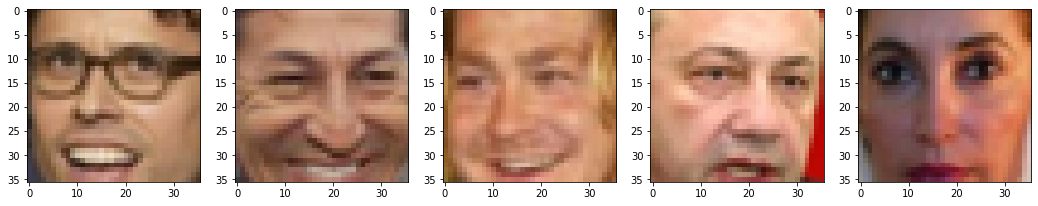

In [5]:
# show some random (real) faces from our dataset

plt.figure(figsize=[18, 18])
plt.axis('off');

for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(data[np.random.randint(data.shape[0])], cmap="gray", interpolation="none")


In [6]:
import tensorflow as tf

# Please don't run tensorfow without this config. Without it you'll take the whole memory of the GPU
# and make it unusable by anyone else
#gpu_options = tf.GPUOptions(allow_growth=True)
#sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
# Edit: for colab, resources are limited on the server-side. Go hog.
sess = tf.compat.v1.InteractiveSession()

tf.compat.v1.disable_eager_execution()
#tf.compat.v1.disable_v2_behavior()


import keras
from keras.models import Sequential
from keras import layers as L
from functools import partial

In [7]:
# If we can't tell good faces from bad, we delegate it to yet another neural network!
# That makes two of them:
# Generator - takes random noise for inspiration and tries to generate a face sample.
# Let's call him G(z), where z is a gaussian noize.
# Discriminator - takes a face sample and tries to tell if it's real or fake.
# Predicts the probability of input image being a real face
# Let's call him D(x), x being an image.
# D(x) is a prediction for real image and D(G(z)) is prediction for the face made by generator.

# Now it's your choise which GAN to build: Jensen-Shannon, or Wasserstein 
# In addition to the theoretical difference, a couple of practical matters: 
#  Jensen-Shannon GAN should learn several times faster, but is more sensitive to mode collapse and vanishing gradients. 
#  Wasserstein GAN doesn't go well in company of batch normalization and ELU activation.

GAN_TYPE = "Jensen-Shannon"
#GAN_TYPE = "Wasserstein"


In [8]:
# Make the Generator. 
#  It takes a random sample as input (size CODE_SIZE) and generates a face with FIGURE_SIZE output size.
#  To enlarge from CODE_SIZE to FIGURE_SIZE (#pix_x by #pix_y by #rgb) you need to use 
#  some Deconvolution2D and UpSampling2D layers.

CODE_SIZE = 512

# Activations experimentally selected. Will most likely work
# for other combinations of activations/architectures
if GAN_TYPE == "Wasserstein":
    generator_activation = partial(keras.activations.relu, alpha=0)
elif GAN_TYPE == "Jensen-Shannon":
    generator_activation = keras.activations.elu

with tf.name_scope("Generator"):
    # A few Deconv layers. Feel free to add more, but that will make learning even slower
    generator = Sequential(name="Generator")
    generator.add(L.InputLayer([CODE_SIZE],name='noise'))
    generator.add(L.Dense(10*8*8, activation=generator_activation))

    ### STUDENT CODE HERE ###
    ### --> Write the network for the Generator.
    ###  It takes a random sample as input (size CODE_SIZE) and generates a face with FIGURE_SIZE output size.
    ###  To enlarge from CODE_SIZE to FIGURE_SIZE (#pix_x by #pix_y by #rgb) you need to use 
    ###  some Conv2DTranspose and UpSampling2D layers. 
    ###  Make sure to use the 'generator_activation' as activation.
    ###  A typical network size has ~300,000 free parameters.
    generator.add(L.Reshape((8,8,10)))

    generator.add(L.Conv2DTranspose(256,kernel_size=(5,5),activation=generator_activation))
    generator.add(L.Conv2DTranspose(128,kernel_size=(5,5),activation=generator_activation))
    
    generator.add(L.UpSampling2D(size=(2,2)))

    generator.add(L.Conv2DTranspose(64,kernel_size=(3,3),activation=generator_activation))
    generator.add(L.Conv2DTranspose(32,kernel_size=(3,3),activation=generator_activation))
    generator.add(L.Conv2DTranspose(32,kernel_size=(3,3),activation=generator_activation))
    
    #The layers become progressivly less detailed as my laptop was just begging for its life everytime I ran the code. Oops!
    #Also because the neural network is already detecting enough detail from the input images to reconstruct images
    ### END STUDENT CODE ###
    
    generator.add(L.Conv2D(3,kernel_size=3,activation="tanh"))

    assert generator.output_shape[1:] == IMG_SHAPE, \
    "generator must output an image of shape %s, but instead it produces %s" % \
        (IMG_SHAPE, generator.output_shape[1:])

    generator.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               328320    
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 10)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 12, 12, 256)       64256     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       819328    
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 34, 34, 64)        73792     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 36, 36, 32)        18

In [9]:
# Make the Discriminator.

# It is your usual convolutional network with interlooping convolution and pooling layers:
#  It takes a figure as input, and a simple output to separate "Yes" (figure is real) and "No" (figure is fake)
# The network does not include dropout/batchnorm to avoid learning complications.
# We also regularize the pre-output layer to prevent discriminator from being too certain.

discriminator_activation = partial(keras.activations.relu, alpha=0.3)

with tf.name_scope("Discriminator"):
    discriminator = Sequential(name="Discriminator")
    discriminator.add(L.InputLayer(IMG_SHAPE))

    ### STUDENT CODE HERE ###
    ### Build the network for the Discriminator. 
    ### Typically described as 'Roughly the inverse of the generator'.
    ### As the discriminator needs to learn complex features, a series of multiple Conv2D 
    ###  layers is recommended, alternated with some MaxPool2D layers to filter out the relevant kernels.
    ### A final Flatten and Dense layer is recommended to learn the interesting combinations of kernels.
    ### Be sure to use the discriminator_activation as activation for each layer.
    ### A typical network has a size of ~400,000 free parameters.

    discriminator.add(L.Conv2D(32, kernel_size=(3,3), activation=discriminator_activation))
    discriminator.add(L.Conv2D(32, kernel_size=(3,3), activation=discriminator_activation))
    discriminator.add(L.MaxPool2D(pool_size=(2, 2)))

    discriminator.add(L.Conv2D(64, kernel_size=(3,3), activation=discriminator_activation))
    discriminator.add(L.Conv2D(64, kernel_size=(3,3), activation=discriminator_activation))
    discriminator.add(L.MaxPool2D(pool_size=(2, 2)))

    discriminator.add(L.Conv2D(128, kernel_size=(3,3), activation=discriminator_activation))
    discriminator.add(L.Conv2D(128, kernel_size=(3,3), activation=discriminator_activation))
    
    discriminator.add(L.Flatten())

    discriminator.add(L.Dense(256, activation=discriminator_activation))

    #Like CNN the deeper the layer the more detailed the detection software will pick out patterns.
    
    ### END STUDENT CODE ###
    
    if GAN_TYPE == "Wasserstein":
        # Wasserstein discriminator values are unconstrained
        discriminator.add(L.Dense(1))
    elif GAN_TYPE == "Jensen-Shannon":
        # Jensen-Shannon expects probabilities
        discriminator.add(L.Dense(2, activation=tf.nn.log_softmax))

    discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 34, 34, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 128)       

In [10]:
# Helper function to create a shuffling image stream for training

def get_tf_dataset(dataset, batch_size):
    """
    Produces an infinite stram of Tensorflow batches from a numpy dataset. The dataset is shuffled every epoch.
    Args:
       dataset: np.array[n_examples, ...]
       batch_size: int, batch size of the results
    Reuturns:
       Tensor, containing the next batch
    """
    if isinstance(dataset, tf.Tensor):
        N_EXAMPLES = dataset.shape[0]
    else:
        N_EXAMPLES = dataset[0].shape[0]
    shuffler = tf.data.experimental.shuffle_and_repeat(N_EXAMPLES)
    dataset_tf = tf.data.Dataset.from_tensor_slices(dataset)
    suffled_ds = shuffler(dataset_tf)
    #return suffled_ds.batch(batch_size).prefetch(1).make_one_shot_iterator().get_next()
    return tf.compat.v1.data.make_one_shot_iterator( suffled_ds.batch(batch_size) ).get_next()


In [11]:
# Initialize training data setup.

# Notes on strategy: we will train the two networks concurrently:
#  - Train discriminator to better distinguish real data from current generator
#  - Train generator to make discriminator think generator is real
# Since discriminator is a differentiable neural network, we train both with gradient descent.
# Training is done iteratively until discriminator is no longer able to find the difference (or until you run out of patience).
# Tricks:
# Train generator with adam to speed up training. Discriminator trains with SGD to avoid problems with momentum.
# More: https://github.com/soumith/ganhacks

# Obtain the training data faces stream for the discriminator
train_batch_size = 100
real_data = get_tf_dataset(data, train_batch_size)

# Generate the noise data to be used in the generator training
noise_batch_size = tf.compat.v1.placeholder(tf.int32, shape=[], name="noise_batch_size")
noise = tf.random.normal([noise_batch_size, CODE_SIZE], dtype=tf.float32, name="noise")

Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


In [12]:
with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:

  # Run data and noise through the networks
  discriminator_real = discriminator(real_data)
  generated_data = generator(noise)
  discriminator_generated = discriminator(generated_data)

  # Configure custom learning and loss details, specific to the GAN strategy type

  if GAN_TYPE == "Wasserstein":
    with tf.name_scope("gradient_loss"):
        alpha = tf.random_uniform(shape=[tf.shape(generated_data)[0], 1, 1, 1], minval=0., maxval=1.)
        interpolates = alpha*real_data + ((1.-alpha)*generated_data)
        disc_interpolates = discriminator(interpolates)
        gradients = tf.gradients(disc_interpolates, [interpolates])[0]
        slopes = tf.norm(tf.reshape(gradients, [tf.shape(gradients)[0], -1]), axis=1)
        gradient_penalty = tf.reduce_mean(tf.square(slopes - 1.))
    EMD_loss = tf.reduce_mean(discriminator_generated) - tf.reduce_mean(discriminator_real)
    LAMBDA = 10.
    discriminator_loss = EMD_loss + LAMBDA*gradient_penalty
    generator_loss = -tf.reduce_mean(discriminator_generated)

  if GAN_TYPE == "Jensen-Shannon":
    logp_real = discriminator(real_data)
    logp_gen = discriminator(generated_data)
    discriminator_loss = -tf.reduce_mean(logp_real[:,1] + logp_gen[:,0])
    generator_loss = -tf.reduce_mean(logp_gen[:,1])

# Get gradients
disc_grads = disc_tape.gradient(discriminator_loss, discriminator.trainable_weights)
gen_grads  = gen_tape.gradient(generator_loss, generator.trainable_weights)

# Define the optimizer for both networks.
# The values below are rough suggestions aimed at not exploding a discriminator
# of complexity roughly equal to the complexity of the generator.
disc_learning_rate = 1e-3

if GAN_TYPE == "Wasserstein":
    # https://arxiv.org/pdf/1704.00028.pdf
    #disc_optimizer = tf.keras.optimizers.Adam(disc_learning_rate, beta1=0, beta2=0.9).minimize(
    #      discriminator_loss, var_list=discriminator.trainable_weights)
    disc_optimizer = tf.keras.optimizers.Adam(disc_learning_rate, beta1=0, beta2=0.9).apply_gradients(
        zip(disc_grads, discriminator.trainable_weights))
elif GAN_TYPE == "Jensen-Shannon":
    #disc_optimizer = tf.keras.optimizers.SGD(disc_learning_rate).minimize(
    #    discriminator_loss, var_list=discriminator.trainable_weights)
    disc_optimizer = tf.keras.optimizers.SGD(disc_learning_rate).apply_gradients(
        zip(disc_grads, discriminator.trainable_weights))    


if GAN_TYPE == "Wasserstein":
    # https://arxiv.org/pdf/1704.00028.pdf
    #gen_optimizer = tf.keras.optimizers.Adam(1e-4, beta1=0, beta2=0.9).minimize(
    #    generator_loss, var_list=generator.trainable_weights)
    gen_optimizer = tf.keras.optimizers.Adam(1e-4, beta1=0, beta2=0.9).apply_gradients(
        zip(gen_grads, generator.trainable_weights))
elif GAN_TYPE == "Jensen-Shannon":
    #gen_optimizer = tf.keras.optimizers.Adam(1e-4).minimize(generator_loss, var_list=generator.trainable_weights)
    gen_optimizer = tf.keras.optimizers.Adam(1e-4).apply_gradients(
        zip(gen_grads, generator.trainable_weights))

learning_summary = tf.compat.v1.summary.merge([
    tf.compat.v1.summary.scalar("discriminator_loss", discriminator_loss),
    tf.compat.v1.summary.scalar("generator_loss", generator_loss)
])

images_summary = tf.compat.v1.summary.image("generated_images", generator(noise))


In [13]:
# initialize all variables.
sess.run(tf.compat.v1.global_variables_initializer())

In [14]:
# Define helper functions to evaluate the Gen. and Disc. over some data batches

def sample_noise_batch(bsize):
    # Get a new batch of noise samples
    return np.random.normal(size=(bsize, CODE_SIZE)).astype('float32')

def sample_data_batch(bsize):
    # Get a batch of real faces
    idxs = np.random.choice(np.arange(data.shape[0]), size=bsize)
    return data[idxs]

def sample_images(nrow,ncol, sharp=False):
    # Let the generator create some faces from noise and show them
    images = generator.predict(sample_noise_batch(bsize=nrow*ncol))
    if np.var(images) != 0:
        images = images.clip(np.min(data),np.max(data))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i].reshape(IMG_SHAPE), cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i].reshape(IMG_SHAPE), cmap="gray")
        plt.axis('off')

def sample_probas(bsize):
    # Let the discriminator predict 'True' or 'False' label for some real and some generated faces.
    #  (note that this is actually a continuous number - a sort of 'probability')
    fig, ax = plt.subplots()
    ax.set_title('Generated vs real data')
    ax.hist(discriminator.predict(sample_data_batch(bsize)).ravel(),
             label='D(x)', alpha=0.5, density=True)
    ax.hist(discriminator.predict(generator.predict(sample_noise_batch(bsize))).ravel(),
             label='D(G(z))', alpha=0.5,  density=True)
    ax.legend(loc='best')
    return fig, ax

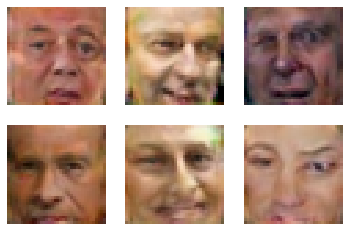

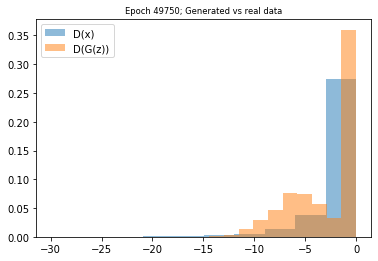

In [15]:
# Actual training

from IPython import display
import os

LOGDIR = "./"
MODEL_NAME = "faces_GAN_%s_noreg_v1" % GAN_TYPE
MODEL_DIR = "./"
os.makedirs(MODEL_DIR, exist_ok=True)
MODEL_WEIGHTS_FILE =  os.path.join(MODEL_DIR, ("%s.ckpt" % MODEL_NAME))
VALIDATION_INTERVAL = 250 # time between intermediate visual updates.
TOTAL_ITERATIONS = int(50e3) # was 5e4 but colab takes too long 
# Number of discriminator training iterations per generator iteration
# In our tests for discriminator of roughly as complexity as discriminator
# 5 worked for both Wasserstein and Jensen–Shannon.
DISCRIMINATOR_ITERATIONS = 5 

# Save the intermediate weights, such that if our training gets interrupted,
#  We don't have to restart from scratch.
train_writer = tf.compat.v1.summary.FileWriter(os.path.join(LOGDIR, MODEL_NAME, "train"))
train_writer.add_graph(tf.compat.v1.get_default_graph())
weights_saver = tf.compat.v1.train.Saver()

if(os.path.exists(MODEL_WEIGHTS_FILE)) :
  try:
    weights_saver.restore(sess, MODEL_WEIGHTS_FILE)
  except (tf.errors.NotFoundError, tf.errors.InvalidArgumentError):
    print("Can't restore parameters: no file with weights")


for epoch in range(TOTAL_ITERATIONS):
    for i in range(DISCRIMINATOR_ITERATIONS):
        # Train the discriminator
        sess.run(disc_optimizer, {noise_batch_size: train_batch_size})
    # Train the generator
    summary, _ = sess.run([learning_summary, gen_optimizer], {noise_batch_size: train_batch_size})

    # write the updated weights
    train_writer.add_summary(summary, epoch)
    
    if epoch % VALIDATION_INTERVAL == 0:
        # display intermediate status and some generated faces.
        display.clear_output(wait=False)
        weights_saver.save(sess, MODEL_WEIGHTS_FILE)
        epoch_images_summary = sess.run(images_summary, {noise_batch_size: 3})
        train_writer.add_summary(epoch_images_summary, epoch)
        sample_images(2, 3, True)
        fig, ax = sample_probas(1000)
        ax.set_title(("Epoch %i; " % epoch) + ax.get_title())
        plt.show()

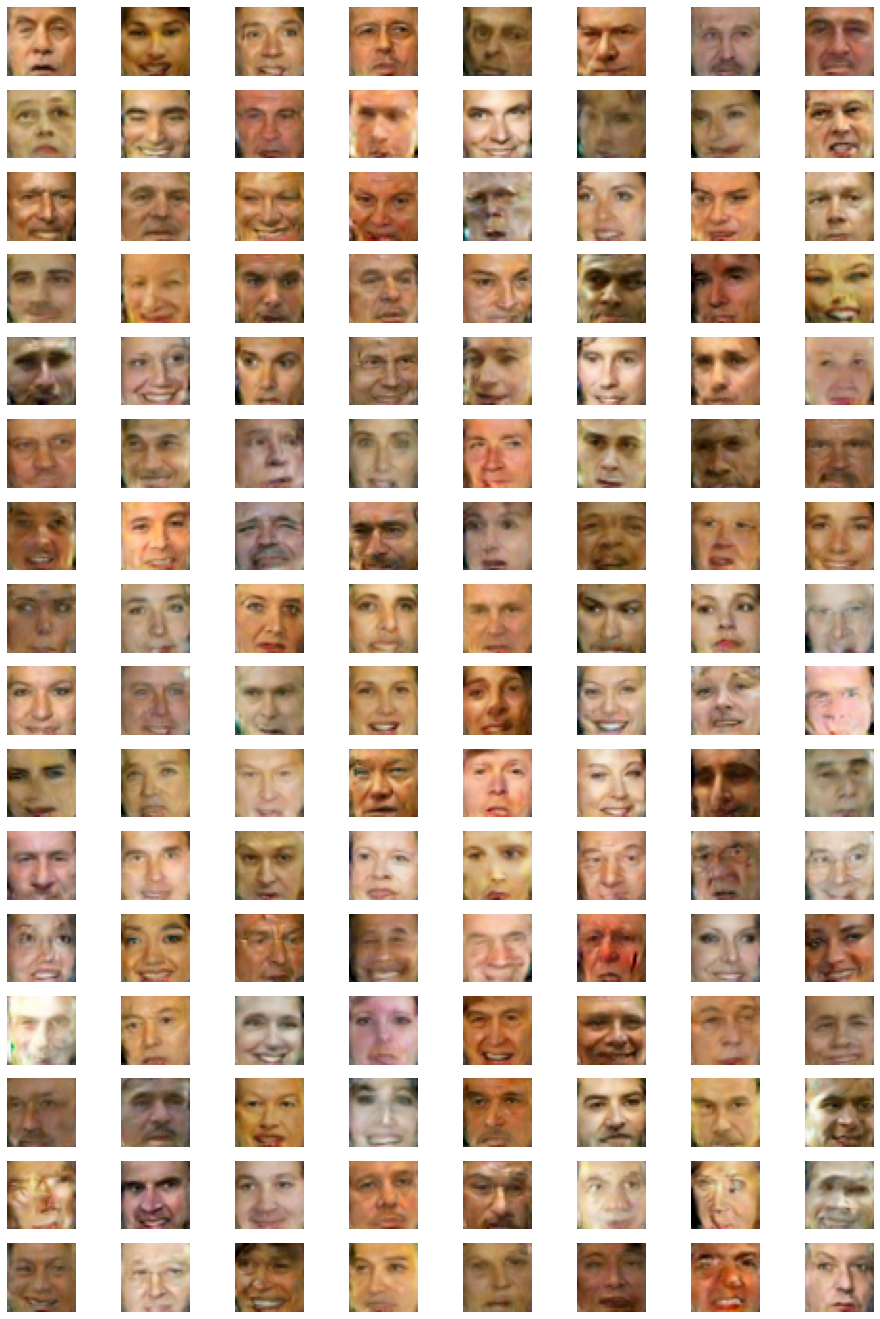

In [16]:
## Show us some generated faces after our training!
plt.figure(figsize=[16, 24])
sample_images(16, 8);